In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import PbmcDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import anndata
import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%matplotlib inline 

# Sets torch and numpy random seeds, run after all scvi imports
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

/data/xiong/anaconda3/envs/scVIC/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getNClusters(data, n_cluster, range_min=0, range_max=4, max_steps=20, verbose=False):
    if isinstance(data, np.ndarray):
        data = anndata.AnnData(X=data)
    assert isinstance(data, anndata.AnnData), \
        "data must be numpy.ndarray or anndata.AnnData"
    this_min = range_min
    this_max = range_max
    for this_step in range(max_steps):
        if verbose:
            print("step: " + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.pp.neighbors(data)
        sc.tl.louvain(data, resolution=this_resolution)
        this_clusters = len(np.unique(data.obs['louvain']))
        if verbose:
            print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        if this_clusters > n_cluster:
            this_max = this_resolution
        if this_clusters < n_cluster:
            this_min = this_resolution
        if this_clusters == n_cluster:
            if not verbose:
                print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
            return data
    print('Cannot find the number of clusters')

In [3]:
save_path = "../Datasets/Biological Datasets"
pbmc_dataset = PbmcDataset(save_path=save_path, save_path_10X=os.path.join(save_path, "10X"))
pbmc_dataset.dense = True
pbmc_dataset.make_gene_names_lower()

[2022-09-18 11:48:17,545] INFO - scvi.dataset.dataset | File /data/xiong/scVIC/notebooks/Datasets/Biological Datasets/gene_info_pbmc.csv already downloaded
[2022-09-18 11:48:17,546] INFO - scvi.dataset.dataset | File /data/xiong/scVIC/notebooks/Datasets/Biological Datasets/pbmc_metadata.pickle already downloaded
[2022-09-18 11:48:17,575] INFO - scvi.dataset.dataset | File /data/xiong/scVIC/notebooks/Datasets/Biological Datasets/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
[2022-09-18 11:48:17,576] INFO - scvi.dataset.dataset10X | Preprocessing dataset
[2022-09-18 11:48:30,609] INFO - scvi.dataset.dataset10X | Finished preprocessing dataset
[2022-09-18 11:48:30,689] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-09-18 11:48:30,691] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-09-18 11:48:30,871] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-09-18 11:48:30,921] INFO - scvi.dataset.dataset | Downsam

In [4]:
n_epochs = 400
lr = 0.001
use_cuda = True
use_batches = False

In [5]:
pbmc_vae = VAE(pbmc_dataset.nb_genes, n_batch=pbmc_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    pbmc_vae,
    pbmc_dataset,
    train_size=1.0,
    use_cuda=use_cuda
)

trainer.train(n_epochs=n_epochs, lr=lr)

[2022-09-18 11:48:47,017] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|███████████████████████████████| 400/400 [09:14<00:00,  1.39s/it]


In [6]:
full = trainer.create_posterior(trainer.model, pbmc_dataset, indices=np.arange(len(pbmc_dataset)))
# Updating the "minibatch" size after training is useful in low memory configurations
full = full.update({"batch_size":32})
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
data = getNClusters(latent, n_cluster=pbmc_dataset.n_labels)
labels_pred = data.obs["louvain"].astype(int)

got 9 at resolution 0.375


In [7]:
post_adata = anndata.AnnData(X=pbmc_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([pbmc_dataset.cell_types[pbmc_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
post_adata.obs['batch'] = np.array([str(pbmc_dataset.batch_indices[i][0])
                                   for i in range(post_adata.n_obs)])
labels_pred=pd.Series(labels_pred, index=post_adata.obs.index, dtype='category')
labels_pred.cat.categories=list(range(len(labels_pred.unique())))
post_adata.obs['predicted_type'] = labels_pred
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)
show_plot = True

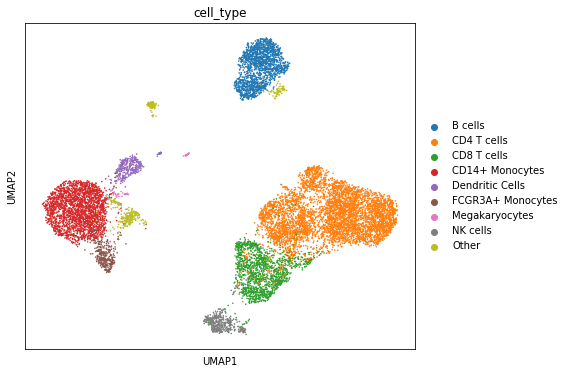

In [8]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

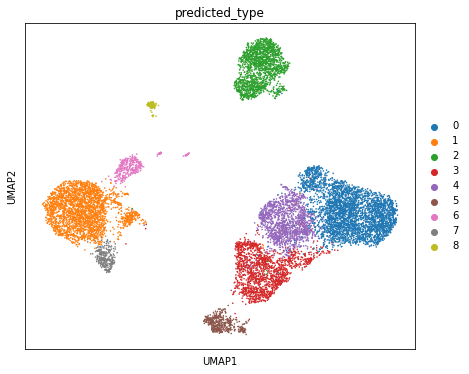

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["predicted_type"], ax=ax, show=show_plot)

In [10]:
ARI = np.around(adjusted_rand_score(pbmc_dataset.labels.squeeze(), labels_pred), 5)
print("PBMC_scVI_Louvain_ARI: ")
print(ARI)
NMI = np.around(normalized_mutual_info_score(pbmc_dataset.labels.squeeze(), labels_pred, average_method='arithmetic'), 5)
print("PBMC_scVI_Louvain_NMI: ")
print(NMI)        

PBMC_scVI_Louvain_ARI: 
0.69427
PBMC_scVI_Louvain_NMI: 
0.78893


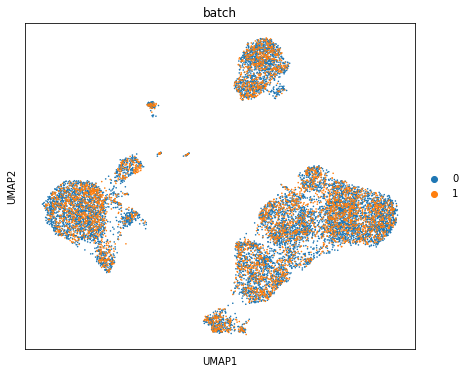

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

In [12]:
from scvic.utils import entropy_batch_mixing
entropy_batch_mixing = np.around(entropy_batch_mixing(latent, pbmc_dataset.batch_indices, pbmc_dataset.n_batches), 5)
print("PBMC_scVI_batch_mixing: ") 
print(entropy_batch_mixing)

PBMC_scVI_batch_mixing: 
0.0144


In [13]:
saved_data = anndata.AnnData(X=latent)
saved_data.obs['cell_type'] = post_adata.obs['cell_type']
saved_data.obs['predicted_type'] = post_adata.obs['predicted_type']
saved_data.obs['batch'] = post_adata.obs['batch']
saved_data.obsm["default_visualization"] = post_adata.obsm["X_umap"]
saved_data.uns["ari"] = ARI
saved_data.uns["nmi"] = NMI
saved_data.uns["entropy_batch_mixing"] = entropy_batch_mixing
saved_data.uns["default_visualization_method"] = 'umap'
saved_data.write_h5ad("../Saved_Data/scVI_Louvain/PBMC_scVI_Louvain_without_BatchRemoval.h5")